### Download libraries needed for this project


In [7]:
import time # for time delay while working with API

import requests # library to handle requests

import bs4 # library to parse webpages

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
import geopy.geocoders

import json # library to handle JSON files

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# k-means from clustering stage
from sklearn.cluster import KMeans

# Map rendering library
import folium

# regular expressions
import re

### Code to scrape the Wikipedia page,in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe:

In [8]:
# extracting table from wikipedia link
from pandas.io.html import read_html
page='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

wikitables = read_html(page, attrs={"class":"wikitable"})
print ("Extracted {num} wikitables".format(num=len(wikitables)))

Extracted 1 wikitables


In [9]:
df=wikitables[0]
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Data Cleaning: 1)Dropping the rows where Borough is 'Not assigned' 2) Combining the neighbourhoods with same Postalcode 3) Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough

In [10]:
# Dropping the rows where Borough is 'Not assigned'
df1 = df[df.Borough != 'Not assigned']

# Combining the neighbourhoods with same Postalcode
df2 = df1.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

# Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough
df2['Neighborhood'] = np.where(df2['Neighborhood'] == 'Not assigned',df2['Borough'], df2['Neighborhood'])
df2.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [5]:
#getting total number of rows & columnns
df2.shape

(103, 3)

### Importing and Reading latitude, longitude csv file

In [12]:
#Importing and Reading latitude, longitude csv file
lat_lon=pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merging two tables

In [13]:
#merge two tables
df3=pd.merge(df2,lat_lon)
df3.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Selecting only Toronto Boroughs

In [14]:
#getting all rows which has toronto in their borough
df4=df3[df3['Borough'].str.contains("Toronto")]
df4.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


### Use geopy library to get the latitude and longitude values of Toronto City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>tor_explorer</em>, as shown below.

In [15]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [16]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df4['Latitude'], df4['Longitude'], df4['Borough'], df4['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

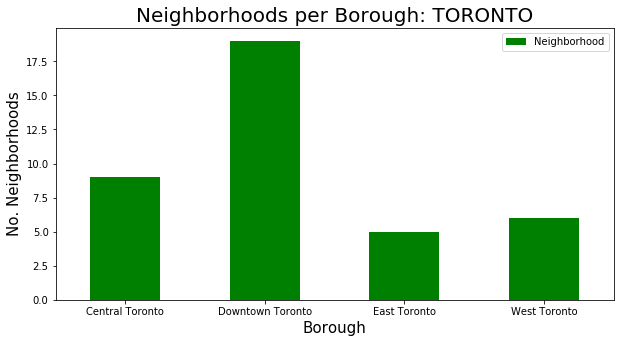

In [17]:
clr = "green"
df4.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: TORONTO', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [18]:
CLIENT_ID = 'NCLMXGMRG2WCVMP0C1NEGMV2LGCGPPVCXWE23PBH4CNG1LM1' # your Foursquare ID
CLIENT_SECRET = 'LNLD140CPBK3FGTAXQZRID4DQHRQ1L0WCSTPNNJXUX3PSXHI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NCLMXGMRG2WCVMP0C1NEGMV2LGCGPPVCXWE23PBH4CNG1LM1
CLIENT_SECRET:LNLD140CPBK3FGTAXQZRID4DQHRQ1L0WCSTPNNJXUX3PSXHI


#### Let's explore the first neighborhood in our dataframe.

In [19]:
#Get the neighborhood's latitude and longitude values.
df3.loc[0, 'Neighborhood']

'Parkwoods'

In [20]:
#Get the neighborhood's latitude and longitude values.
neighborhood_latitude = df3.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df3.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df3.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


#### Now, let's get the top 100 venues that are in Parkwoods within a radius of 500 meters.


First, let's create the GET request URL. Name your URL url.

In [42]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=restaurant'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=NCLMXGMRG2WCVMP0C1NEGMV2LGCGPPVCXWE23PBH4CNG1LM1&client_secret=LNLD140CPBK3FGTAXQZRID4DQHRQ1L0WCSTPNNJXUX3PSXHI&v=20180605&ll=43.7532586,-79.3296565&radius=500&limit=100&query=restaurant'

In [43]:
#Send the GET request and examine the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f11f4629abab31a23c81f4d'},
 'response': {'warning': {'text': 'There aren\'t a lot of results for "restaurant." Try something more general, reset your filters, or expand the search area.'},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'query': 'restaurant',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e6696b6d16433b9ffff47c3',
       'name': 'KFC',
       'location': {'lat': 43.75438666345904,
        'lng': -79.3330206627504,
        'labeledLatLngs': [{'label':

### From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [44]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [45]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,KFC,Fast Food Restaurant,43.754387,-79.333021
1,Bella Vita Catering & Private Chef Service,BBQ Joint,43.756651,-79.331524


In [46]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

2 venues were returned by Foursquare.


### Explore Neighborhoods in Toronto

#### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [74]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={0}&client_secret={1}&v={2}&ll={3},{4}&radius={5}&limit={6}&query=restaurant'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            #v['venue']['location']['lat'], 
            #v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  #'Venue Latitude', 
                  #'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [75]:
toronto_venues = getNearbyVenues(names=df4['Neighborhood'],
                                   latitudes=df4['Latitude'],
                                   longitudes=df4['Longitude']
                                  )

#### Let's check the size of the resulting dataframe

In [76]:
print(toronto_venues.shape)
toronto_venues.head()

(1364, 5)


,Location,Latitude,Longitude,Venue,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,Restaurant
1,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,Breakfast Spot
2,"Regent Park, Harbourfront",43.65426,-79.360636,Figs Breakfast & Lunch,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Brick Street Bakery,Bakery
4,"Regent Park, Harbourfront",43.65426,-79.360636,Cluny Bistro & Boulangerie,French Restaurant


In [77]:
toronto_venues[['Location', 'Venue']].groupby('Location').count()

,Venue
Location,
Berczy Park,52
"Brockton, Parkdale Village, Exhibition Place",15
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",5
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",2
Central Bay Street,69
Christie,7
Church and Wellesley,64
"Commerce Court, Victoria Hotel",100
Davisville,30


And check if Foursquare API did not return restaurants for some locations.

In [78]:
x = toronto_venues[['Location', 'Venue']].groupby('Location').count().shape[0]
y = df4.shape[0]
empty_locations = []
if x != y:
    print('Missing data for {0} locations:'.format(y-x))
    # And print them
    for i in range(df4.shape[0]):
        loc = df4.iloc[i,0]
        k = 0
        for j in range(toronto_venues.shape[0]):
            if loc == toronto_venues.iloc[j,0]:
                k += 1
        if k == 0:
            print(i,loc)
            empty_locations.append(loc)

Missing data for 1 locations:
0 M5A
1 M7A
2 M5B
3 M5C
4 M4E
5 M5E
6 M5G
7 M6G
8 M5H
9 M6H
10 M5J
11 M6J
12 M4K
13 M5K
14 M6K
15 M4L
16 M5L
17 M4M
18 M4N
19 M5N
20 M4P
21 M5P
22 M6P
23 M4R
24 M5R
25 M6R
26 M4S
27 M5S
28 M6S
29 M4T
30 M5T
31 M4V
32 M5V
33 M4W
34 M5W
35 M4X
36 M5X
37 M4Y
38 M7Y


#### Let's find out how many unique categories can be curated from all the returned venues

In [79]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 89 uniques categories.


##  Analyze Each Neighborhood for Indian Restaurants

In [80]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Location'] = toronto_venues['Location'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Location,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [81]:
toronto_onehot.shape

(1364, 90)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [82]:
venues_grouped = toronto_onehot.groupby('Location').mean().reset_index()
venues_grouped

,Location,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Berczy Park,0.000000,0.019231,0.000000,0.00000,0.000000,0.019231,0.019231,0.076923,0.019231,0.038462,0.000000,0.019231,0.000000,0.000000,0.000000,0.057692,0.0000,0.000000,0.000000,0.000000,0.019231,0.019231,0.00000,0.000000,0.0,0.038462,0.000000,0.000000,0.000000,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.019231,0.019231,0.057692,0.019231,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.019231,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231,0.000000,0.000000,0.153846,0.000000,0.019231,0.038462,0.000000,0.000000,0.000000,0.00000,0.000000,0.019231,0.057692,0.000000,0.000000,0.019231,0.019231,0.000000,0.038462,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.133333,0.000000,0.066667,0.000000,0.200000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

#### Let's confirm the new size

In [83]:
venues_grouped.shape

(38, 90)

Let's print each neighborhood along with the top 5 most common venues

In [84]:
num_top_venues = 5

for hood in venues_grouped['Location']:
    print("----"+hood+"----")
    temp = venues_grouped[venues_grouped['Location'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0          Restaurant  0.15
1              Bakery  0.08
2                Café  0.06
3  Italian Restaurant  0.06
4    Sushi Restaurant  0.06


----Brockton, Parkdale Village, Exhibition Place----
                 venue  freq
0                 Café  0.20
1           Restaurant  0.13
2       Breakfast Spot  0.13
3               Bakery  0.13
4  Japanese Restaurant  0.07


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Fast Food Restaurant   0.4
1           Pizza Place   0.2
2            Restaurant   0.2
3         Burrito Place   0.2
4     Afghan Restaurant   0.0


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0  American Restaurant   0.5
1     Tapas Restaurant   0.5
2   Mexican Restaurant   0.0
3          Pizza Place   0.0
4   Persian Restaurant   0.0


----Central Bay

### Let's put that into a pandas dataframe¶

First, let's write a function to sort the venues in descending order.

In [85]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [86]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Location'] = venues_grouped['Location']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Restaurant,Bakery,Italian Restaurant,Café,Sushi Restaurant,Moroccan Restaurant,Diner,Bistro,Seafood Restaurant,Greek Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Bakery,Restaurant,Breakfast Spot,Italian Restaurant,Burrito Place,Japanese Restaurant,Sandwich Place,Pizza Place,Vietnamese Restaurant
2,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Restaurant,Burrito Place,Pizza Place,Wings Joint,Eastern European Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",American Restaurant,Tapas Restaurant,Wings Joint,Falafel Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,Central Bay Street,Café,Sandwich Place,Italian Restaurant,Restaurant,Japanese Restaurant,Chinese Restaurant,Pizza Place,Thai Restaurant,Fried Chicken Joint,Indian Restaurant
5,Christie,Restaurant,Café,Diner,Italian Restaurant,Japanese Restaurant,Wings Joint,Ethiopian Restaurant,Dim Sum Restaurant,Doner Restaurant,Donut Shop
6,Church and Wellesley,Japanese Restaurant,Sushi Restaurant,Pizza Place,Burger Joint,Restaurant,Vietnamese Restaurant,Mexican Restaurant,Mediterranean Restaurant,Burrito Place,Korean Restaurant
7,"Commerce Court, Victoria Hotel",Restaurant,Café,Italian Restaurant,Salad Place,American Restaurant,Japanese Restaurant,Breakfast Spot,Deli / Bodega,Seafood Restaurant,Vegetarian / Vegan Restaurant
8,Davisville,Pizza Place,Café,Restaurant,American Restaurant,Italian Restaurant,Sushi Restaurant,Greek Restaurant,Seafood Restaurant,Fried Chicken Joint,Indian Restaurant
9,Davisville North,Breakfast Spot,Asian Restaurant,Restaurant,Pizza Place,Ethiopian Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop


In [87]:
venues_grouped.columns.values.tolist()

['Location',
 'Afghan Restaurant',
 'American Restaurant',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Belgian Restaurant',
 'Bistro',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Burger Joint',
 'Burrito Place',
 'Cafeteria',
 'Café',
 'Cajun / Creole Restaurant',
 'Caribbean Restaurant',
 'Chinese Restaurant',
 'Colombian Restaurant',
 'Comfort Food Restaurant',
 'Creperie',
 'Cuban Restaurant',
 'Deli / Bodega',
 'Dim Sum Restaurant',
 'Diner',
 'Doner Restaurant',
 'Donut Shop',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Empanada Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'Fish & Chips Shop',
 'Food',
 'Food Court',
 'Food Truck',
 'French Restaurant',
 'Fried Chicken Joint',
 'Gastropub',
 'German Restaurant',
 'Gluten-free Restaurant',
 'Greek Restaurant',
 'Hot Dog Joint',
 'Indian Restaurant',
 'Irish Pub',
 'Italian Restaurant',

## Cluster Restaurants

Run *k*-means to cluster the neighborhood into 5 clusters.

In [145]:
# set number of clusters
kclusters = 5

venues_grouped_clustering = venues_grouped.drop('Location', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 4, 2, 2, 2, 2, 2, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.Do not forget that some location didn't get any data from Foursquare API, and we put them to the list.
Therfore we are forced to exclude them from the resulting dataset.

In [176]:
tor_merged = df4

# Substitute all empty locations by NAN
for loc in empty_locations:
    tor_merged = tor_merged.replace(loc, np.nan)



In [177]:
# then drop all rows containing NAN
tor_merged.dropna(subset=['Neighborhood'], axis=0, inplace=True)
tor_merged.reset_index(drop=True, inplace=True)
print('Now the cluster dataframe has {0} data rows.'.format(tor_merged.shape[0]))

Now the cluster dataframe has 39 data rows.


In [178]:
# merge toronto_grouped with df4 to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(neighborhoods_venues_sorted.set_index('Location'), on='Neighborhood')

tor_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,NaN,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2.0,Café,Restaurant,Breakfast Spot,Bakery,Chinese Restaurant,Mexican Restaurant,Seafood Restaurant,Italian Restaurant,Greek Restaurant,Thai Restaurant
1,NaN,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2.0,Sushi Restaurant,Japanese Restaurant,Diner,Restaurant,Mexican Restaurant,Café,Chinese Restaurant,Creperie,Deli / Bodega,Middle Eastern Restaurant
2,NaN,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2.0,Restaurant,Café,Pizza Place,Middle Eastern Restaurant,Fast Food Restaurant,Japanese Restaurant,Bakery,Burger Joint,Thai Restaurant,Italian Restaurant
3,NaN,Downtown Toronto,St. James Town,43.651494,-79.375418,2.0,Restaurant,Italian Restaurant,Café,Sushi Restaurant,Bakery,American Restaurant,Breakfast Spot,Gastropub,Creperie,Moroccan Restaurant
4,NaN,East Toronto,The Beaches,43.676357,-79.293031,2.0,Burger Joint,Asian Restaurant,Pizza Place,Wings Joint,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant


In [179]:
# Deleted potal code column  due to NaN
del tor_merged['Postal Code']
tor_merged = tor_merged[tor_merged['Cluster Labels'].notna()]
tor_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2.0,Café,Restaurant,Breakfast Spot,Bakery,Chinese Restaurant,Mexican Restaurant,Seafood Restaurant,Italian Restaurant,Greek Restaurant,Thai Restaurant
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2.0,Sushi Restaurant,Japanese Restaurant,Diner,Restaurant,Mexican Restaurant,Café,Chinese Restaurant,Creperie,Deli / Bodega,Middle Eastern Restaurant
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2.0,Restaurant,Café,Pizza Place,Middle Eastern Restaurant,Fast Food Restaurant,Japanese Restaurant,Bakery,Burger Joint,Thai Restaurant,Italian Restaurant
3,Downtown Toronto,St. James Town,43.651494,-79.375418,2.0,Restaurant,Italian Restaurant,Café,Sushi Restaurant,Bakery,American Restaurant,Breakfast Spot,Gastropub,Creperie,Moroccan Restaurant
4,East Toronto,The Beaches,43.676357,-79.293031,2.0,Burger Joint,Asian Restaurant,Pizza Place,Wings Joint,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
5,Downtown Toronto,Berczy Park,43.644771,-79.373306,2.0,Restaurant,Bakery,Italian Restaurant,Café,Sushi Restaurant,Moroccan Restaurant,Diner,Bistro,Seafood Restaurant,Greek Restaurant
6,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2.0,Café,Sandwich Place,Italian Restaurant,Restaurant,Japanese Restaurant,Chinese Restaurant,Pizza Place,Thai Restaurant,Fried Chicken Joint,Indian Restaurant
7,Downtown Toronto,Christie,43.669542,-79.422564,2.0,Restaurant,Café,Diner,Italian Restaurant,Japanese Restaurant,Wings Joint,Ethiopian Restaurant,Dim Sum Restaurant,Doner Restaurant,Donut Shop
8,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,2.0,Restaurant,Café,Asian Restaurant,Salad Place,Sandwich Place,American Restaurant,Thai Restaurant,Sushi Restaurant,Deli / Bodega,Bakery
9,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,2.0,Pizza Place,Bakery,Portuguese Restaurant,Middle Eastern Restaurant,Café,Brazilian Restaurant,Empanada Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant


In [180]:
tor_merged.columns.values.tolist()

['Borough',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'Cluster Labels',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue']

### Results

And now we are ready to conclude our report.

#### Examine Clusters

Let's examine each cluster and the discriminating restaurant categories that distinguish a cluster.

##### Cluster 1

In [181]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Forest Hill North & West, Forest Hill Road Park",Restaurant,French Restaurant,Sushi Restaurant,Wings Joint,Empanada Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
29,"Moore Park, Summerhill East",Restaurant,Wings Joint,Ethiopian Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant


In [182]:
cluster_1 = tor_merged.loc[tor_merged['Cluster Labels'] == 0, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
cluster_1.describe(include='all')

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,2,2,2,2,2,2,2,2,2,2,2
unique,2,1,2,2,2,2,2,2,2,2,2
top,"Moore Park, Summerhill East",Restaurant,French Restaurant,Sushi Restaurant,Wings Joint,Empanada Restaurant,Diner,Doner Restaurant,Diner,Doner Restaurant,Eastern European Restaurant
freq,1,2,1,1,1,1,1,1,1,1,1


##### Cluster 2

In [183]:
tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Rosedale,Japanese Restaurant,Wings Joint,Falafel Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant


In [184]:
cluster_2 = tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
cluster_2.describe(include='all')

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1
top,Rosedale,Japanese Restaurant,Wings Joint,Falafel Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
freq,1,1,1,1,1,1,1,1,1,1,1


##### Cluster 3

In [185]:
tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",Café,Restaurant,Breakfast Spot,Bakery,Chinese Restaurant,Mexican Restaurant,Seafood Restaurant,Italian Restaurant,Greek Restaurant,Thai Restaurant
1,"Queen's Park, Ontario Provincial Government",Sushi Restaurant,Japanese Restaurant,Diner,Restaurant,Mexican Restaurant,Café,Chinese Restaurant,Creperie,Deli / Bodega,Middle Eastern Restaurant
2,"Garden District, Ryerson",Restaurant,Café,Pizza Place,Middle Eastern Restaurant,Fast Food Restaurant,Japanese Restaurant,Bakery,Burger Joint,Thai Restaurant,Italian Restaurant
3,St. James Town,Restaurant,Italian Restaurant,Café,Sushi Restaurant,Bakery,American Restaurant,Breakfast Spot,Gastropub,Creperie,Moroccan Restaurant
4,The Beaches,Burger Joint,Asian Restaurant,Pizza Place,Wings Joint,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
5,Berczy Park,Restaurant,Bakery,Italian Restaurant,Café,Sushi Restaurant,Moroccan Restaurant,Diner,Bistro,Seafood Restaurant,Greek Restaurant
6,Central Bay Street,Café,Sandwich Place,Italian Restaurant,Restaurant,Japanese Restaurant,Chinese Restaurant,Pizza Place,Thai Restaurant,Fried Chicken Joint,Indian Restaurant
7,Christie,Restaurant,Café,Diner,Italian Restaurant,Japanese Restaurant,Wings Joint,Ethiopian Restaurant,Dim Sum Restaurant,Doner Restaurant,Donut Shop
8,"Richmond, Adelaide, King",Restaurant,Café,Asian Restaurant,Salad Place,Sandwich Place,American Restaurant,Thai Restaurant,Sushi Restaurant,Deli / Bodega,Bakery
9,"Dufferin, Dovercourt Village",Pizza Place,Bakery,Portuguese Restaurant,Middle Eastern Restaurant,Café,Brazilian Restaurant,Empanada Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant


In [186]:
cluster_3 = tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
cluster_3.describe(include='all')

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,33,33,33,33,33,33,33,33,33,33,33
unique,33,13,14,16,18,22,24,28,26,22,26
top,"The Annex, North Midtown, Yorkville",Restaurant,Café,Restaurant,Pizza Place,Italian Restaurant,Restaurant,Café,Dim Sum Restaurant,Diner,Donut Shop
freq,1,9,7,5,5,5,3,2,3,3,3


##### Cluster 4

In [187]:
tor_merged.loc[tor_merged['Cluster Labels'] == 3, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Lawrence Park,Dim Sum Restaurant,Wings Joint,Gluten-free Restaurant,Deli / Bodega,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant


In [188]:
cluster_4 = tor_merged.loc[tor_merged['Cluster Labels'] == 3, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
cluster_4.describe(include='all')

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1
top,Lawrence Park,Dim Sum Restaurant,Wings Joint,Gluten-free Restaurant,Deli / Bodega,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
freq,1,1,1,1,1,1,1,1,1,1,1


##### Cluster 5

In [189]:
tor_merged.loc[tor_merged['Cluster Labels'] == 4, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,"CN Tower, King and Spadina, Railway Lands, Har...",American Restaurant,Tapas Restaurant,Wings Joint,Falafel Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant


In [190]:
cluster_5 = tor_merged.loc[tor_merged['Cluster Labels'] == 4, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
cluster_5.describe(include='all')

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1
top,"CN Tower, King and Spadina, Railway Lands, Har...",American Restaurant,Tapas Restaurant,Wings Joint,Falafel Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
freq,1,1,1,1,1,1,1,1,1,1,1


### Visualizing Clusters

Finally, let's visualize the resulting clusters

In [194]:
int(cluster)

2

In [197]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], tor_merged['Neighborhood'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### MAP LEGEND
###### Cluster 1 - red dots
###### Cluster 2 - purple dots
###### Cluster 3 - blue dots
###### Cluster 4 - green dots
###### Cluster 5 - orange dots